In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import gpytorch
from gp import HeteroskedasticGP


## Plot toy data

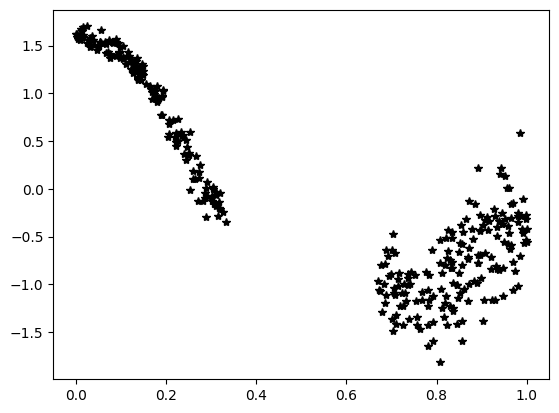

In [5]:
train_x = np.random.uniform(8, 20, 500)

train_y = (0.1 * train_x ** 2 - 3.5*train_x + np.cos(train_x*1.3) + 40 
           + np.random.normal(0, 0.01, len(train_x)) * train_x**2 * 0.3)

# Create some "gap" in the data
# to test epistemic uncertainty
# estimation:
gap_mask = (train_x<12) | (train_x>16)
train_x = train_x[gap_mask]
train_y = train_y[gap_mask]

# Scaling:
train_x = (train_x - train_x.min()) / (train_x.max() - train_x.min())
train_y = (train_y - train_y.mean()) / train_y.std()

# Plot training data:
plt.plot(train_x, train_y, 'k*')

In [7]:

# Instantiate model:
pyro.clear_param_store()  # Good practice
model = HeteroskedasticGP()

num_iter = 1000
num_particles = 256

# training routine:
def train():
    optimizer = pyro.optim.Adam({"lr": 0.01})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

    model.train()
    iterator = range(num_iter)
    for i in iterator:
        model.zero_grad()
        loss = svi.step(torch.from_numpy(train_x).float().unsqueeze(1), torch.from_numpy(train_y).float())
        print(loss)

# Train the GP:
train()


687.0530242919922
587.9230194091797
532.4208221435547
514.5489654541016
498.22100830078125
491.5661315917969
488.0364227294922
484.5618591308594
481.7176208496094
477.5595245361328
473.04273986816406
468.2181396484375
463.31239318847656
457.9425811767578
452.70220947265625
447.7086181640625
441.8710174560547
435.91966247558594
430.6512451171875
423.84893798828125
416.60626220703125
410.4359436035156
402.56922912597656
395.6246795654297
387.76451110839844
379.9356384277344
372.57310485839844
365.1274871826172
358.4808349609375
351.74560546875
346.1676788330078
341.3155212402344
337.4373474121094
333.4154052734375
329.24974060058594
326.17417907714844
322.4779357910156
319.9682159423828
316.7823791503906
313.78033447265625
311.0836486816406
306.80206298828125
302.3262481689453
297.8213806152344
292.3931427001953
288.0192565917969
282.5057678222656
277.2561950683594
272.2161407470703
266.4747314453125
261.04884338378906
254.31910705566406
246.91688537597656
240.46310424804688
232.76409912

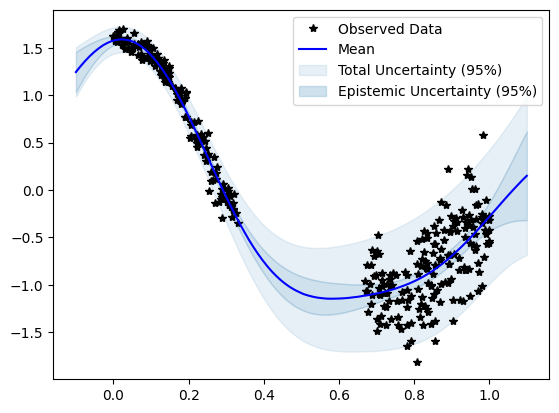

In [8]:
# Function to plot predictions:
def plot_preds(ax, feature, mean_samples, var_samples, bootstrap=True, n_boots=100,
               show_epistemic=False, epistemic_mean=None, epistemic_var=None):
    """Plots the overall mean and variance of the aggregate system.
    Inherited from https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Heteroskedastic.html.

    We can represent the overall uncertainty via explicitly sampling the underlying normal
    distributrions (with `bootstrap=True`) or as the mean +/- the standard deviation from
    the Law of Total Variance. 
    
    For systems with many observations, there will likely be
    little difference, but in cases with few observations and informative priors, plotting
    the percentiles will likely give a more accurate representation.
    """
    if bootstrap:
        means = np.expand_dims(mean_samples.T, axis=2)
        stds = np.sqrt(np.expand_dims(var_samples.T, axis=2))
        
        samples_shape = mean_samples.T.shape + (n_boots,)
        samples = np.random.normal(means, stds, samples_shape)
        
        reshaped_samples = samples.reshape(mean_samples.shape[1], -1).T
        
        l, m, u = [np.percentile(reshaped_samples, p, axis=0) for p in [2.5, 50, 97.5]]
        ax.plot(feature, m, label="Median", color="b")
    
    else:
        m = mean_samples.mean(axis=0)
        sd = np.sqrt(mean_samples.var(axis=0) + var_samples.mean(axis=0))
        l, u = m - 1.96 * sd, m + 1.96 * sd
        ax.plot(feature, m, label="Mean", color="b")
    
    if show_epistemic:
        ax.fill_between(feature,
                        l,
                        epistemic_mean-1.96*np.sqrt(epistemic_var), 
                        alpha=0.2,
                        color="#88b4d2",
                        label="Total Uncertainty (95%)")
        ax.fill_between(feature, 
                        u, 
                        epistemic_mean+1.96*np.sqrt(epistemic_var), 
                        alpha=0.2,
                        color="#88b4d2")
        ax.fill_between(feature, 
                        epistemic_mean-1.96*np.sqrt(epistemic_var), 
                        epistemic_mean+1.96*np.sqrt(epistemic_var),
                        alpha=0.4,
                        color="#88b4d2",
                        label="Epistemic Uncertainty (95%)")
    else:
        ax.fill_between(feature, 
                        l, 
                        u, 
                        alpha=0.2,
                        color="#88b4d2",
                        label="Total Uncertainty (95%)")

# Test data to predict:
x_padding = 0.1

test_x = torch.linspace(train_x.min() - (train_x.max() - train_x.min()) * x_padding, 
                        train_x.max() + (train_x.max() - train_x.min()) * x_padding, 
                        100).float()

# Predict:
model.eval()
with torch.no_grad():
    output_dist = model(test_x)

# Extract predictions:
output_samples = output_dist.sample(torch.Size([1000]))
mu_samples = output_samples[...,0]
sigma_samples = torch.exp(output_samples[...,1])

# Plot predictions:
plt.plot(train_x, train_y, 'k*', label="Observed Data")
ax = plt.gca()
plot_preds(ax, 
           test_x.numpy(),
           mu_samples.numpy(), 
           sigma_samples.numpy()**2,
           bootstrap=False, 
           n_boots=100,
           show_epistemic=True,
           epistemic_mean=output_dist.mean[:,0].detach().numpy(),
           epistemic_var=output_dist.stddev[:,0].detach().numpy()**2)
ax.legend();